In [1]:
from sklearn.metrics import mean_absolute_error,mean_squared_error
from sklearn.model_selection import KFold,train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import lightgbm as lgb
import pandas as pd 
import numpy as np
from math import *
from featexp import *
import gc
import os
path_train='D:/data_mywork/math_modeling/train_set/'
path_test='D:/data_mywork/math_modeling/test_set/'
path_dir=os.listdir(path_train)
path_dir1=os.listdir(path_test)

In [2]:
def feat(data):
    feat=['Frequency Band','RS Power','Cell Clutter Index','Clutter Index']
    train_x=data.loc[:,feat]
    train_x['d']=5*np.sqrt((data['Cell X']-data['X'])**2+(data['Cell Y']-data['Y'])**2)
    train_x['Hb']=data['Cell Altitude']+data['Cell Building Height']
    train_x['Hue']=data['Altitude']+data['Building Height']
    train_x['Hb-Hue']=train_x['Hb']-train_x['Hue']
    train_x['thetaM']=np.radians(data['Mechanical Downtilt'])
    train_x['thetaE']=np.radians(data['Electrical Downtilt'])
    train_x['thetaME']=train_x['thetaM']+train_x['thetaE']
    train_x['dHv']=train_x['Hb']-train_x['d']*np.tan(train_x['thetaME'])
    train_x['Hb-Hue-dHv']=train_x['Hb-Hue']-train_x['dHv']
    train_x['Hb-Ha-dHv']=train_x['Hb']-data['Altitude']-train_x['dHv']
    train_x['Hue-dHv']=train_x['Hue']-train_x['dHv']
    
    train_x['theta_uc']=np.arctan2(train_x['Hb-Hue'],train_x['d'])
    #train_x['log_freq']=np.log10(data['Frequency Band'])
    train_x['log_Hb']=np.log10(train_x['Hb']+1)
    train_x['log_Hue']=np.log10(train_x['Hue']+1)
    train_x['log_d']=np.log10(train_x['d']+1)
    train_x['dmulHue_log']=train_x['log_Hue']*train_x['log_d']
    train_x['log_dHv']=np.log10(abs(train_x['dHv'])+1)
    train_x['log_Hb-Hue']=np.log10(abs(train_x['Hb-Hue'])+1)
    train_x['log_Hb-Hue-dHv']=np.log10(abs(train_x['Hb-Hue-dHv'])+1)
    train_x['log_Hb-Ha-dHv']=np.log10(abs(train_x['Hb-Ha-dHv'])+1)
    train_x['log_Hue-dHv']=np.log10(abs(train_x['Hue-dHv'])+1)
    
    train_x['Azimuth_rad']=np.radians(data['Azimuth'])
    train_x['dX']=data['X']-data['Cell X']
    train_x['dY']=data['Y']-data['Cell Y']
    train_x['theta_XY']=np.arctan2(train_x['dX'],train_x['dY'])
    train_x['theta_XY'].loc[train_x['dY']<0]=train_x['theta_XY'].loc[train_x['dY']<0]+pi
    train_x['theta_XY'].loc[(train_x['dY']>=0)&(train_x['dX']<0)]=train_x['theta_XY'].loc[(train_x['dY']>=0)&(train_x['dX']<0)]+2*pi
    train_x['theta_XY_A']=train_x['theta_XY']-train_x['Azimuth_rad']
    
    train_x['Larc']=np.sin(train_x['theta_XY_A']/2)*train_x['d']
    train_x['theta_T']=np.arctan2(train_x['Hue-dHv'],train_x['Larc'])
    feat_drop=['d','Hb','Hue','Hb-Hue','thetaM','thetaE','Hb-Hue-dHv','dHv',
               'Hb-Ha-dHv','Hue-dHv','log_d','log_Hb-Hue','log_Hb-Ha-dHv',
               'log_Hue-dHv','dmulHue_log','Azimuth_rad','theta_XY','dX','dY']
    train_x=train_x.drop(feat_drop,axis=1)
    return train_x



In [70]:
#改进版
def get_demical(x):
    return modf(x)[0]
def feat(data):
    feat=['Frequency Band','RS Power','Cell Clutter Index','Clutter Index']
    lambdaf=299792458/data['Frequency Band']/1e6
    train_x=data.loc[:,feat]
    train_x['thetaME']=np.radians(data['Mechanical Downtilt']+data['Electrical Downtilt'])
    #train_x['lambda']=lambdaf
    #train_x['logFreq']=np.log10(data['Frequency Band']*1e6)
    train_x['d']=np.sqrt((data['Cell X']-data['X'])**2+(data['Cell Y']-data['Y'])**2)
    train_x['Hb']=data['Cell Altitude']+data['Height']
    train_x['Hu']=data['Altitude']+data['Building Height']
    train_x['HuA']=data['Altitude']                               
    train_x['Hb-Hu']=train_x['Hb']-train_x['Hu']
    train_x['Hb-HuA']=train_x['Hb']-train_x['HuA']                               
    train_x['dHv']=train_x['Hb']-train_x['d']*np.tan(train_x['thetaME'])
    train_x['Hb-Hu-dHv']=train_x['Hb-Hu']-train_x['dHv']
    train_x['Hb-HuA-dHv']=train_x['Hb-HuA']-train_x['dHv']
    train_x['Hu-dHv']= train_x['HuA']-train_x['dHv']                              
    train_x['HuA-dHv']=train_x['HuA']-train_x['dHv']
    
    train_x['theta_b-u']=np.arctan2(train_x['Hb-Hu'],train_x['d'])-train_x['thetaME']
    train_x['theta_b-uA']=np.arctan2(train_x['Hb-HuA'],train_x['d'])-train_x['thetaME']
    #train_x['reflectSign1']=np.sign(train_x['theta_b-u'])
    #train_x['reflectSign2']=np.sign(train_x['theta_b-uA'])  
    train_x['log_Hb']=np.log10(train_x['Hb']+1)
    train_x['log_Hu']=np.log10(train_x['Hu']+1) 
    train_x['log_HuA']=np.log10(train_x['HuA']+1)
    train_x['log_dHv']=np.log10(abs(train_x['dHv'])+1)
    train_x['log_Hb-Hu']=np.log10(abs(train_x['Hb-Hu'])+1)
    train_x['log_Hb-HuA']=np.log10(abs(train_x['Hb-HuA'])+1) 
    train_x['log_Hb-Hu-dHv']=np.log10(abs(train_x['Hb-Hu-dHv'])+1)
    train_x['log_Hb-HuA-dHv']=np.log10(abs(train_x['Hb-HuA-dHv'])+1)
    
    train_x['Azimuth_rad']=np.radians(data['Azimuth'])
    train_x['dX']=data['X']-data['Cell X']
    train_x['dY']=data['Y']-data['Cell Y']
    train_x['theta_XY']=np.arctan2(train_x['dX'],train_x['dY'])
    train_x['theta_XY'][train_x['dY']<0]=train_x['theta_XY'].loc[train_x['dY']<0]+pi
    train_x['theta_XY'][(train_x['dY']>=0)&(train_x['dX']<0)]=train_x['theta_XY'].loc[(train_x['dY']>=0)&(train_x['dX']<0)]+2*pi
    train_x['theta_XY_A']=train_x['theta_XY']-train_x['Azimuth_rad']
    
    train_x['Larc']=np.sin(train_x['theta_XY_A']/2)*train_x['d']
    train_x['theta_T']=np.arctan2(train_x['Hu-dHv'],train_x['Larc'])
    train_x['theta_T1']=np.arctan2(train_x['HuA-dHv'],train_x['Larc'])
    train_x['logLarc']=np.log10(abs(train_x['Larc'])+1)
    train_x['Amplitude']=data['RS Power']*np.cos(train_x['thetaME'])*np.cos(train_x['theta_XY_A'])
    train_x['dAmplitude']=train_x['Amplitude']*np.cos(2*pi*((train_x['d']/lambdaf).map(get_demical)))
    train_x['dHvAmplitude']=train_x['dAmplitude']*np.cos(2*pi*((train_x['dHv']/lambdaf).map(get_demical)))
    
    train_x['cos_thetaME']=np.cos(train_x['thetaME'])
    train_x['cos_theta_T']=np.cos(train_x['theta_T'])
    train_x['cos_theta_b-u']=np.cos(train_x['theta_b-u'])
    train_x['cos_theta_b-uA']=np.cos(train_x['theta_b-uA'])
    train_x['cos_theta_XY_A']=np.cos(train_x['theta_XY_A'])
    feat_drop=['Azimuth_rad','theta_XY','dX','dY']
    train_x=train_x.drop(feat_drop,axis=1)
    return train_x


In [4]:
#dummies=pd.get_dummies(train_set[['Cell Clutter Index','Clutter Index']].astype('object'))

In [27]:
#groups=train_set.groupby('Clutter Index')
#for key,group in groups:
#    print(key,group.shape[0])

In [6]:
#读取训练数据
train_data=[]
for f in path_dir:
    train_data.append(pd.read_csv(path_train+f))
train_data=pd.concat(train_data).reset_index(drop=True) 
#读取测试数据
test_data=[]
for f in path_dir1:
    test_data.append(pd.read_csv(path_test+f))
test_data=pd.concat(test_data).reset_index(drop=True) 

CellIndex=test_data['Cell Index']

In [71]:
#训练数据转化
train_set=[]
chunk=1000000
for i in range(1,14):
    train_x=feat(train_data[(i-1)*chunk:i*chunk])
    train_set.append(train_x)
train_set=pd.concat(train_set)
train_set['RSRP']=train_data['RSRP']
#测试数据转化
test_set=feat(test_data)
#del train_data

#按Frequency Band分3类,做成dict
def DataDivison(data_set):
    groups=data_set.groupby('Frequency Band')
    data_sets={}
    for key,group in groups:
        group=group.drop(['Frequency Band'],axis=1)
        data_sets[key]=group
    return data_sets


C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:40: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\lenovo\Anaconda3\lib\site-packages\ipykernel_launcher.py:41: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [72]:
#分别建模
train_sets=DataDivison(train_set)
test_sets=DataDivison(test_set)
dataSetKey=[2585.0, 2604.8, 2624.6]
#按类别训练并预测
#result=pd.DataFrame()
#result['CellIndex']=CellIndex
#for key in test_sets.keys():
#    oof,predictions,feature_importance_df=lgb_reg(params,train_sets[key][features],train_set[key]['label'],test_sets[key][features])
#    result['predict'].loc[test_sets[key].index]=predictions
#result.to_csv(path_result+'result.csv')


In [22]:
#随机抽取5%的数据，约50W条，用来训练模型
#trainSet1,ValSet1=train_test_split(train_set,test_size=0.05, random_state=2019)
#trainSet2,ValSet2=train_test_split(ValSet1,test_size=0.25, random_state=2020)
#del train_set
#gc.collect()

In [73]:
features=train_sets[2604.8].columns.tolist()[:-1]

                                          Plots for RS Power                                          
                                           Train data plots                                           


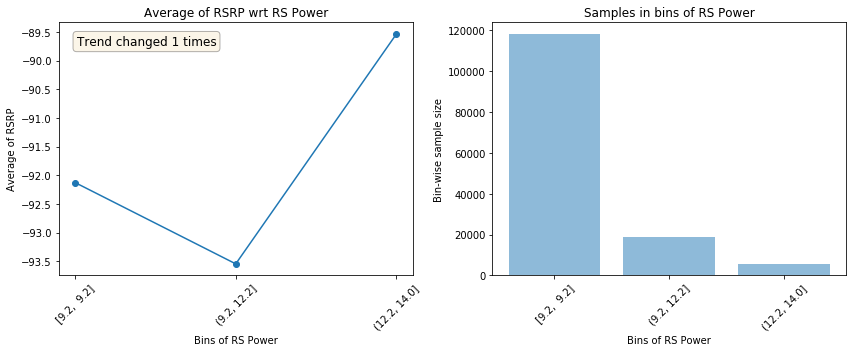

                                           Test data plots                                            


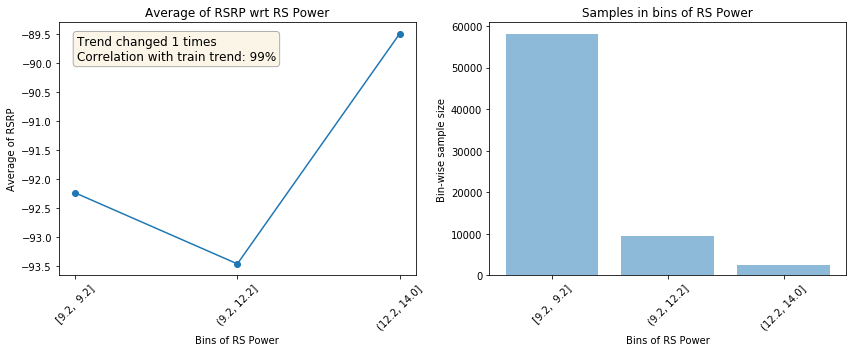

--------------------------------------------------------------------------------------------------------------


                                     Plots for Cell Clutter Index                                     
                                           Train data plots                                           


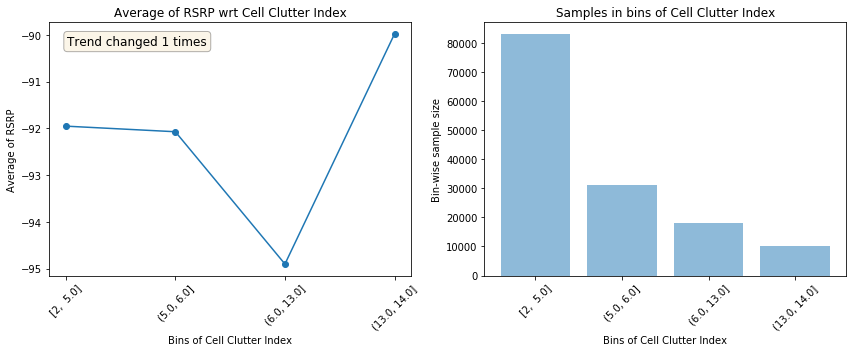

                                           Test data plots                                            


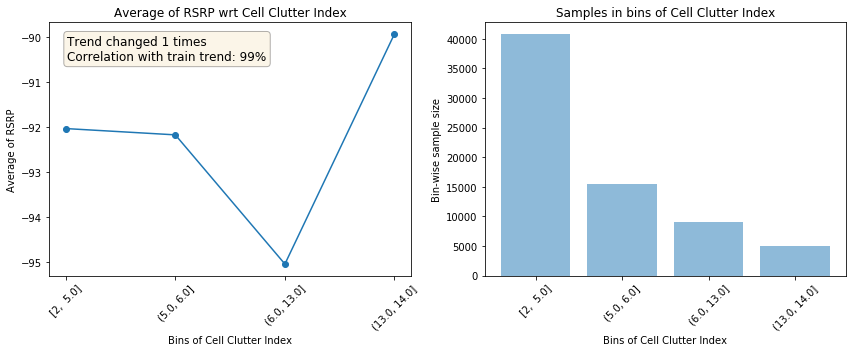

--------------------------------------------------------------------------------------------------------------


                                       Plots for Clutter Index                                        
                                           Train data plots                                           


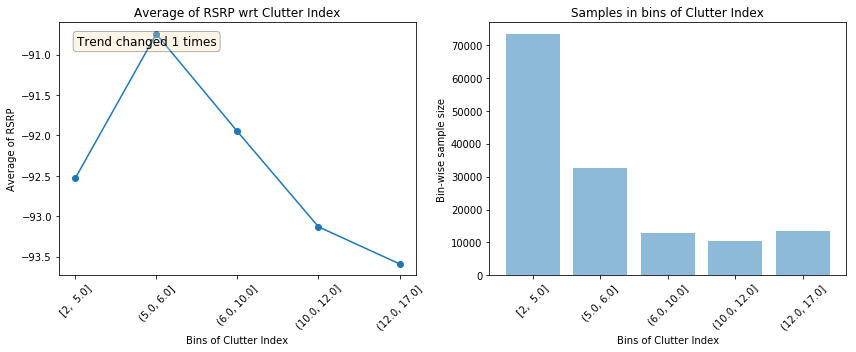

                                           Test data plots                                            


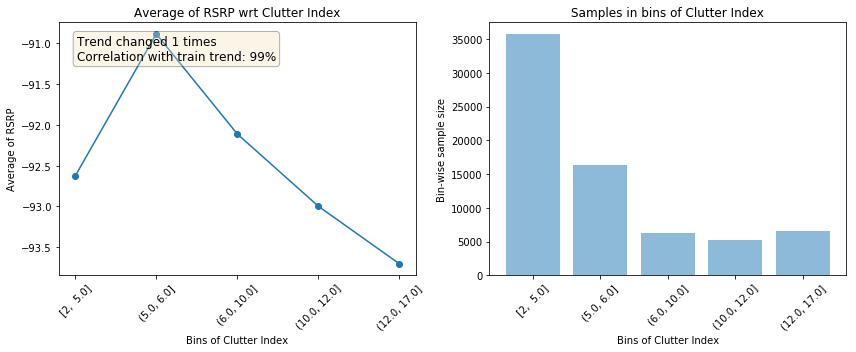

--------------------------------------------------------------------------------------------------------------


                                          Plots for thetaME                                           
                                           Train data plots                                           


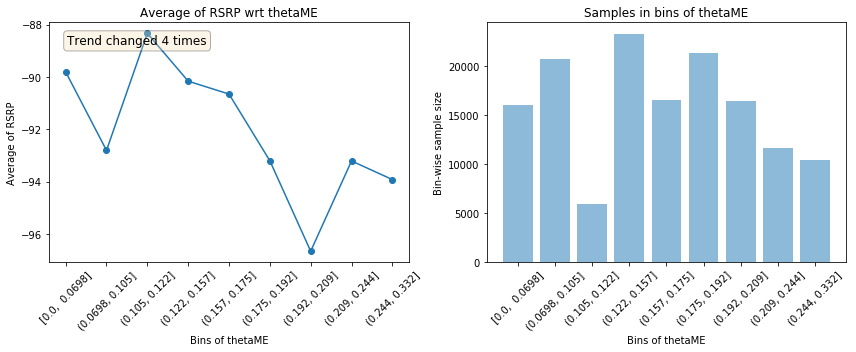

                                           Test data plots                                            


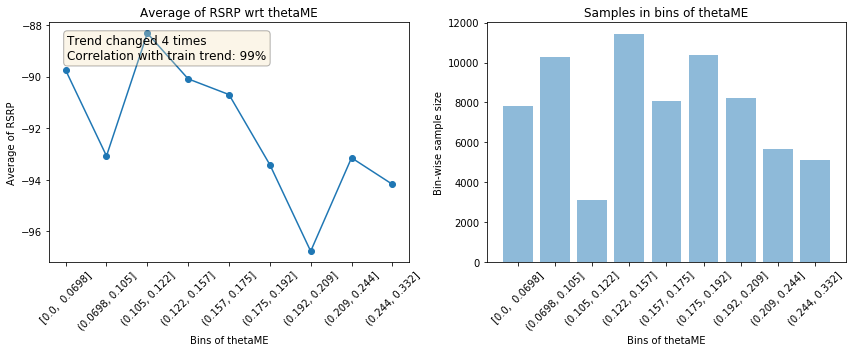

--------------------------------------------------------------------------------------------------------------


                                             Plots for d                                              
                                           Train data plots                                           


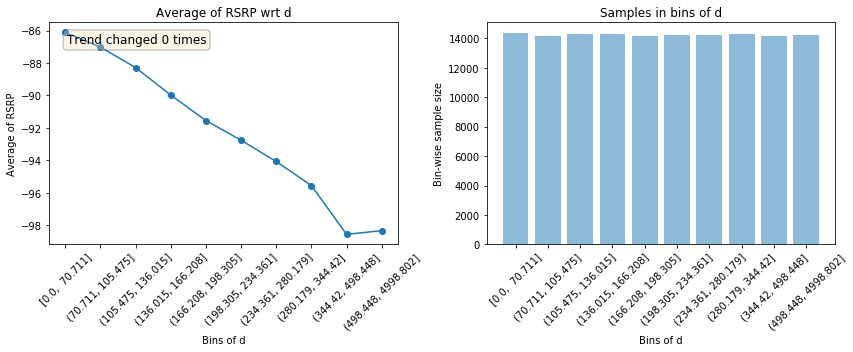

                                           Test data plots                                            


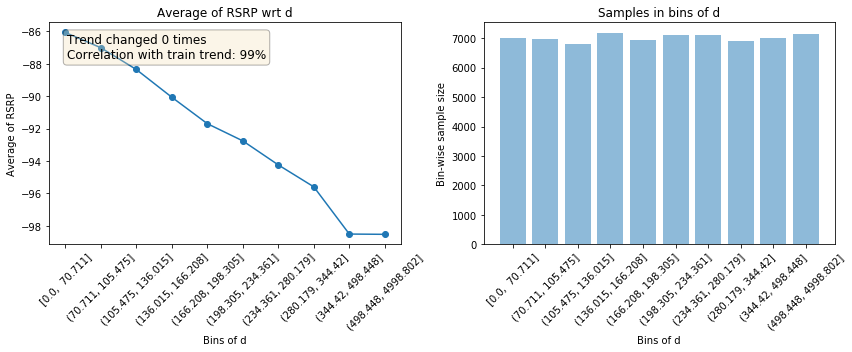

--------------------------------------------------------------------------------------------------------------


                                             Plots for Hb                                             
                                           Train data plots                                           


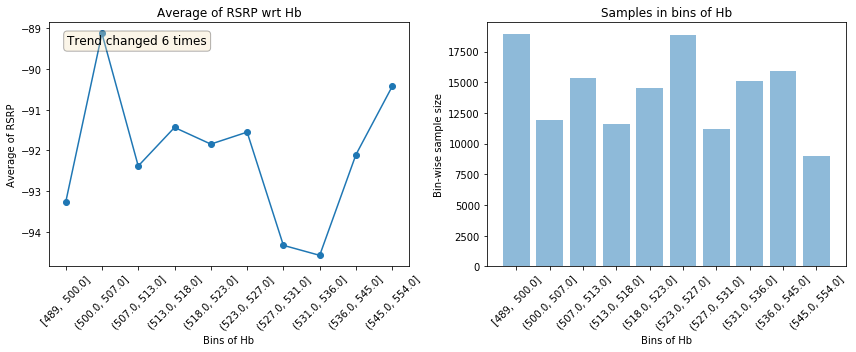

                                           Test data plots                                            


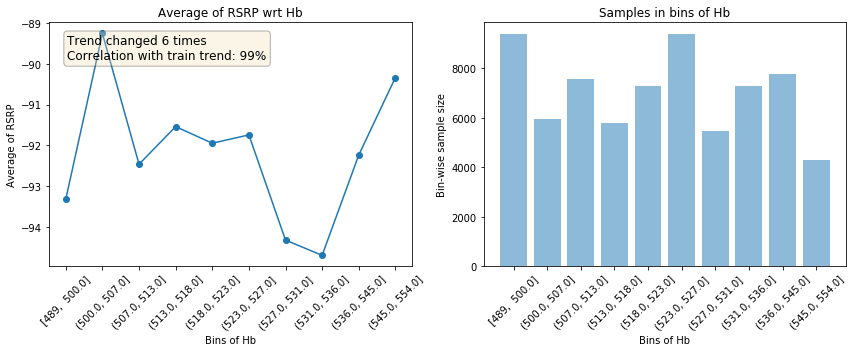

--------------------------------------------------------------------------------------------------------------


                                             Plots for Hu                                             
                                           Train data plots                                           


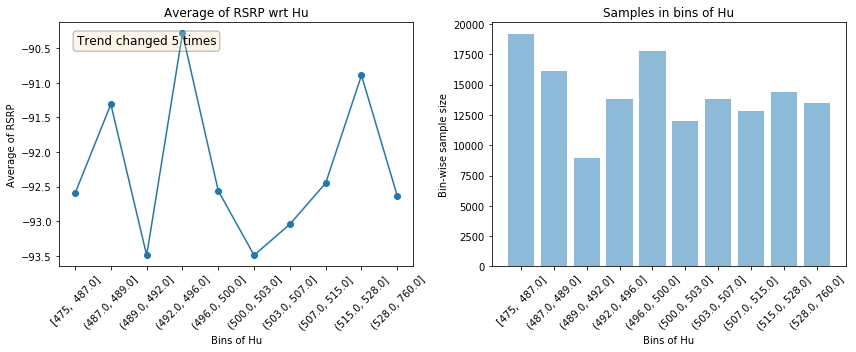

                                           Test data plots                                            


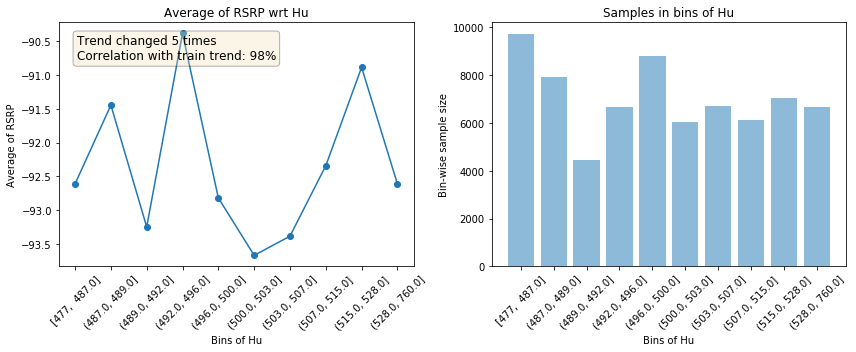

--------------------------------------------------------------------------------------------------------------


                                            Plots for HuA                                             
                                           Train data plots                                           


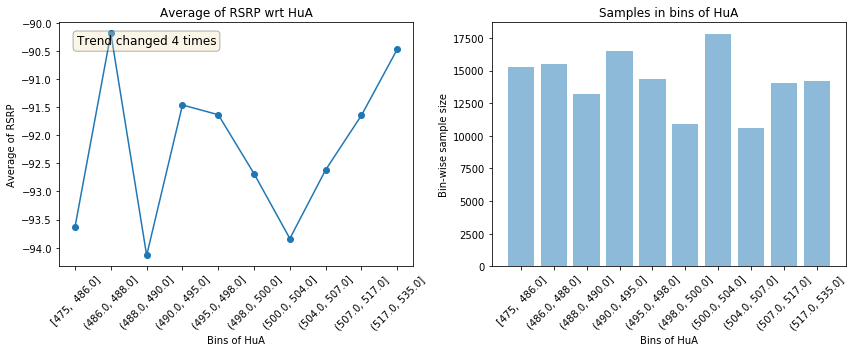

                                           Test data plots                                            


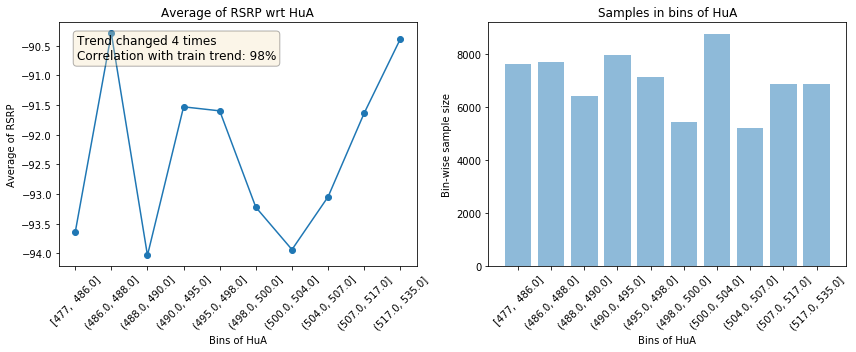

--------------------------------------------------------------------------------------------------------------


                                           Plots for Hb-Hu                                            
                                           Train data plots                                           


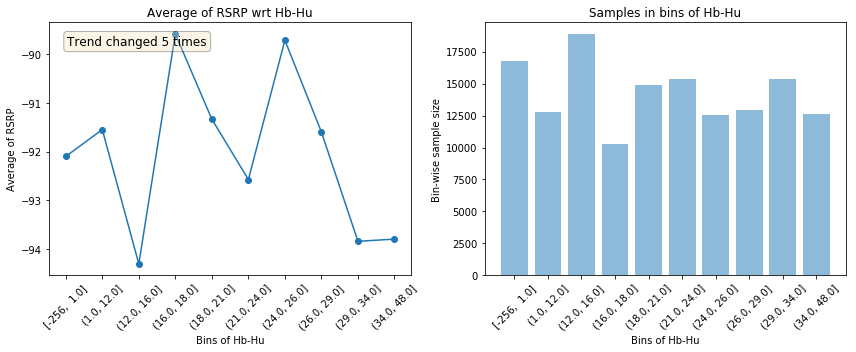

                                           Test data plots                                            


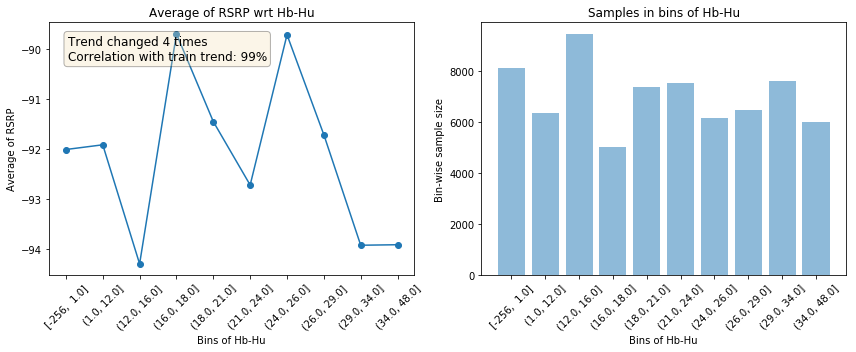

--------------------------------------------------------------------------------------------------------------


                                           Plots for Hb-HuA                                           
                                           Train data plots                                           


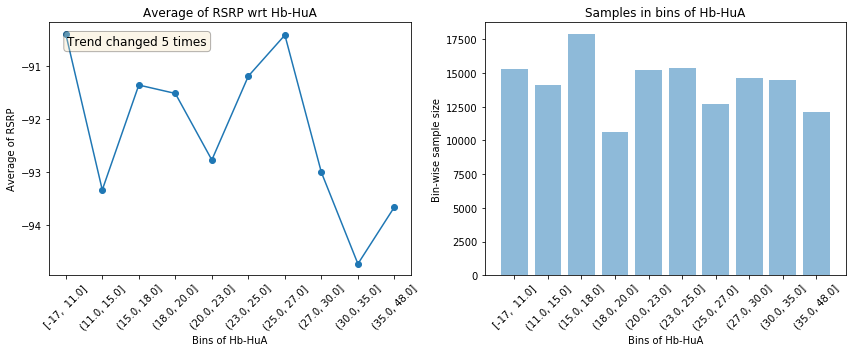

                                           Test data plots                                            


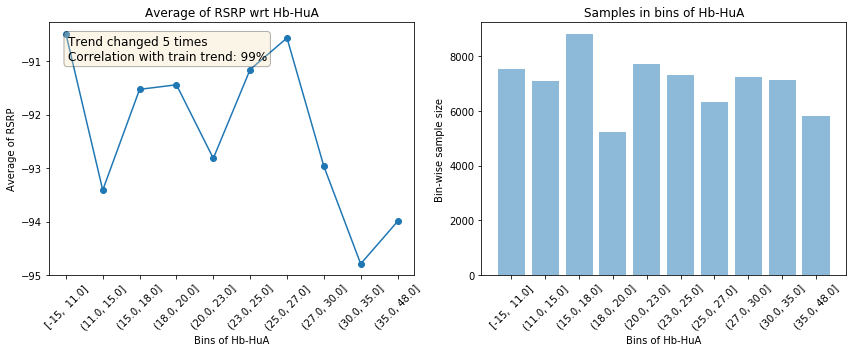

--------------------------------------------------------------------------------------------------------------


                                            Plots for dHv                                             
                                           Train data plots                                           


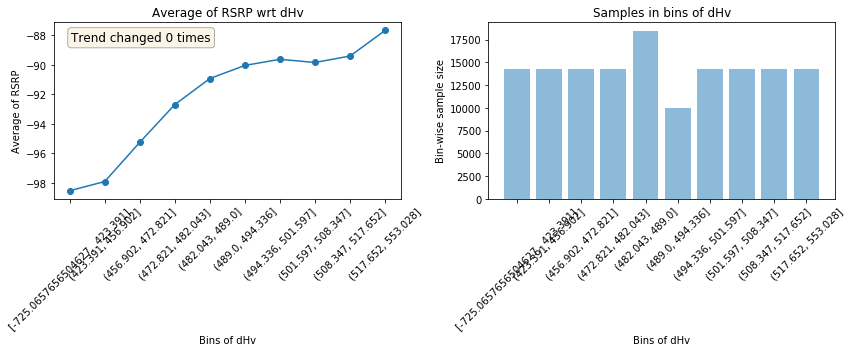

                                           Test data plots                                            


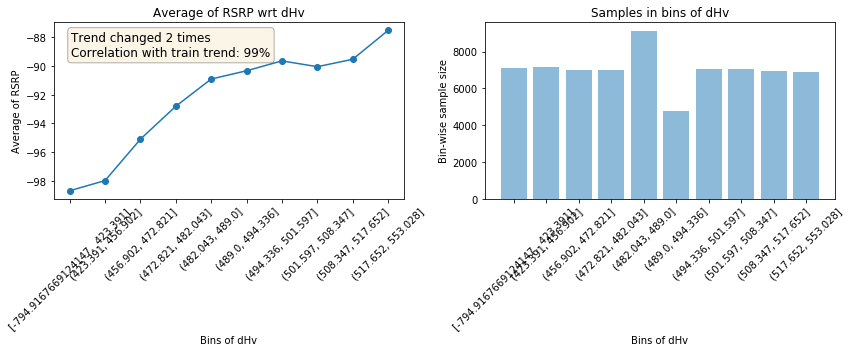

--------------------------------------------------------------------------------------------------------------


                                         Plots for Hb-Hu-dHv                                          
                                           Train data plots                                           


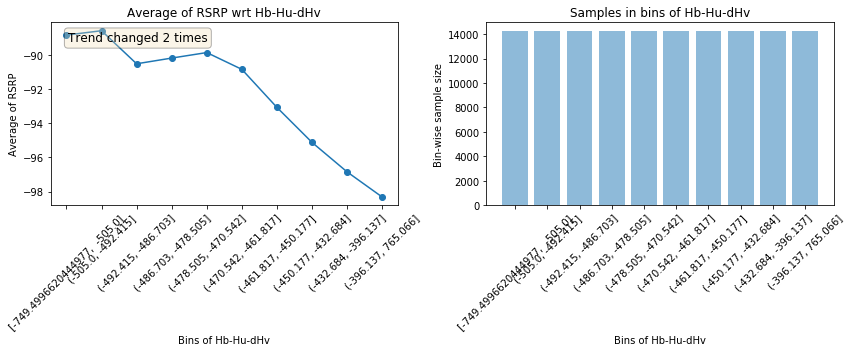

                                           Test data plots                                            


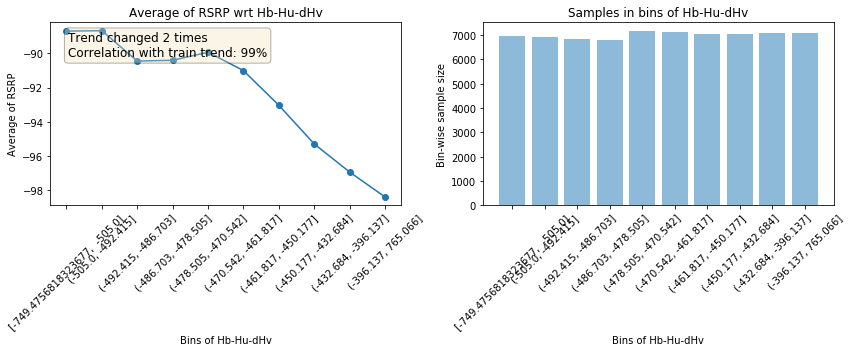

--------------------------------------------------------------------------------------------------------------


                                         Plots for Hb-HuA-dHv                                         
                                           Train data plots                                           


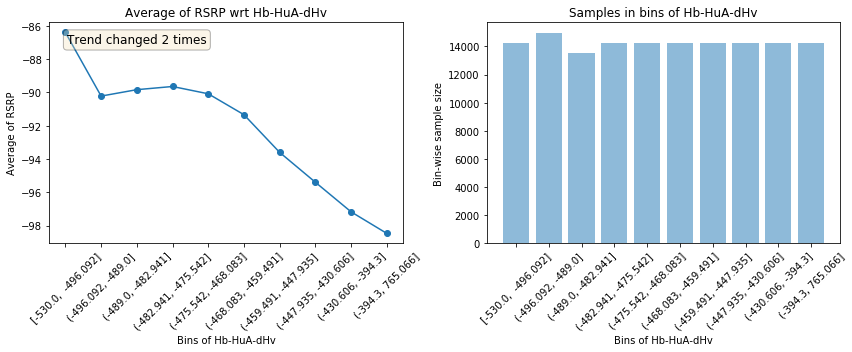

                                           Test data plots                                            


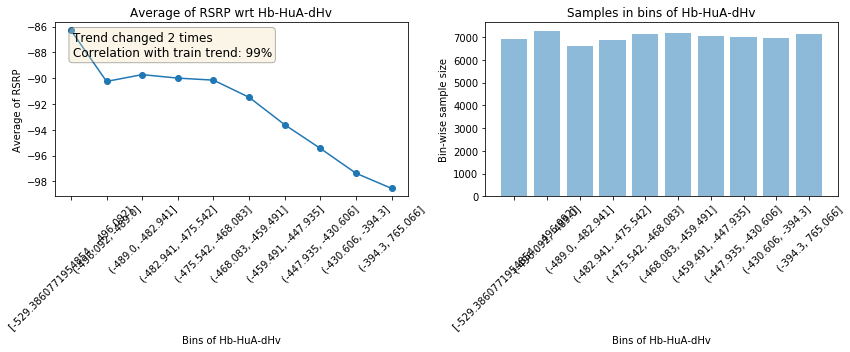

--------------------------------------------------------------------------------------------------------------


                                           Plots for Hu-dHv                                           
                                           Train data plots                                           


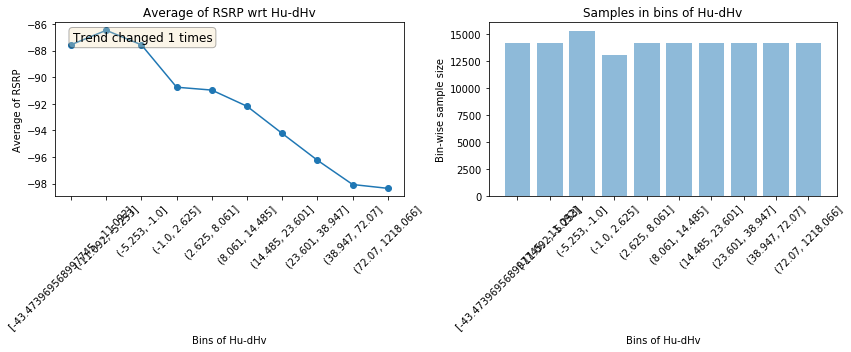

                                           Test data plots                                            


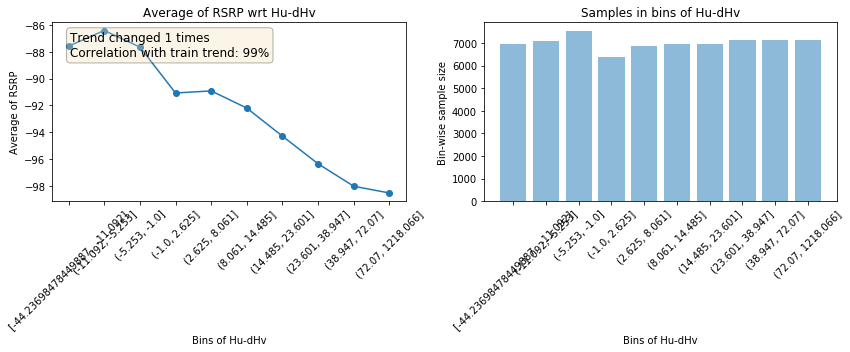

--------------------------------------------------------------------------------------------------------------


                                          Plots for HuA-dHv                                           
                                           Train data plots                                           


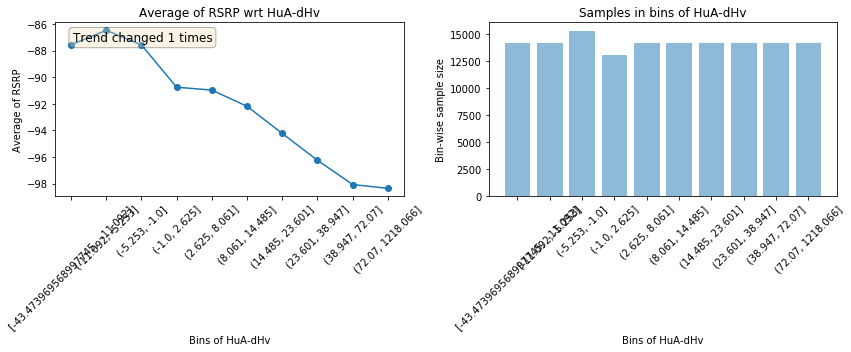

                                           Test data plots                                            


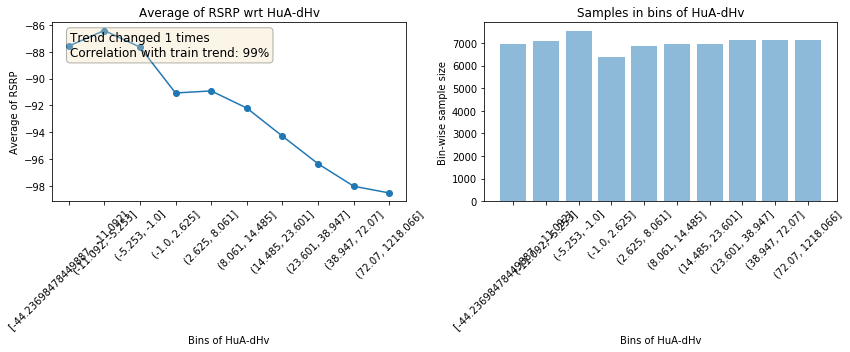

--------------------------------------------------------------------------------------------------------------


                                         Plots for theta_b-u                                          
                                           Train data plots                                           


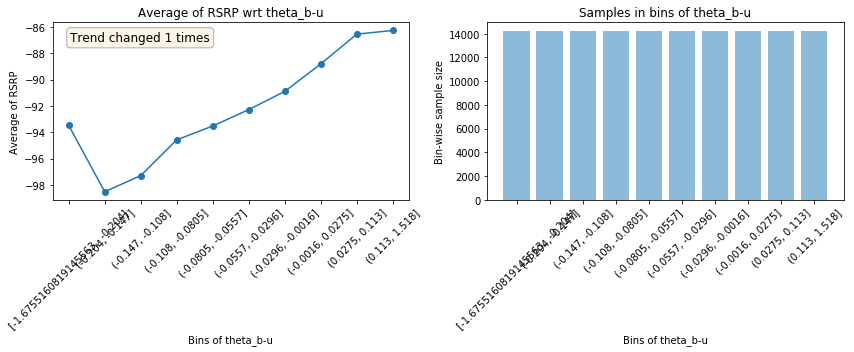

                                           Test data plots                                            


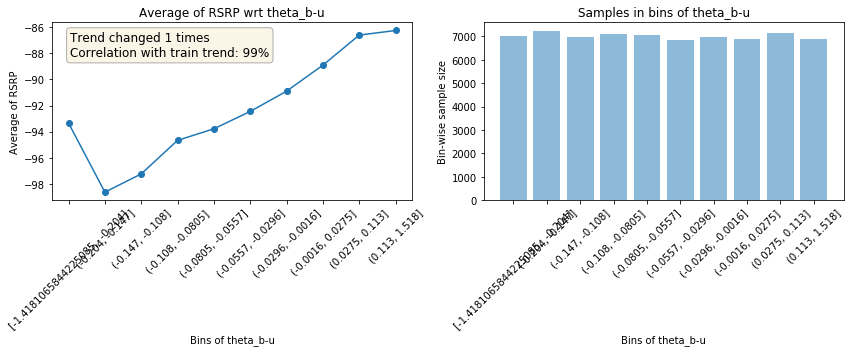

--------------------------------------------------------------------------------------------------------------


                                         Plots for theta_b-uA                                         
                                           Train data plots                                           


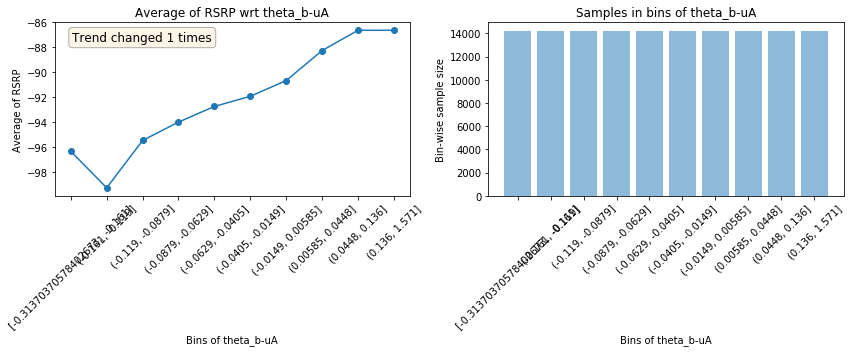

                                           Test data plots                                            


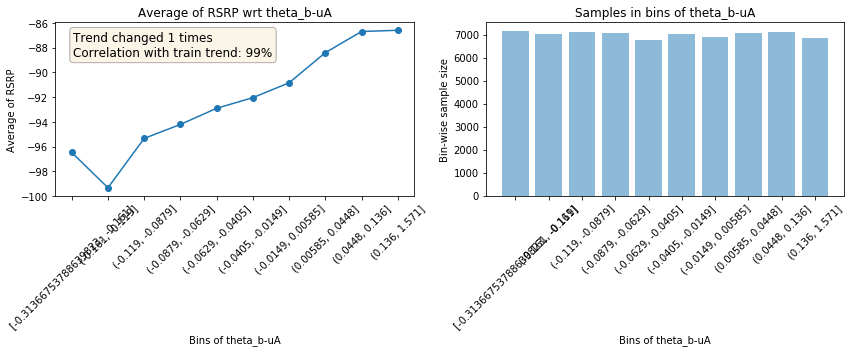

--------------------------------------------------------------------------------------------------------------


                                           Plots for log_Hb                                           
                                           Train data plots                                           


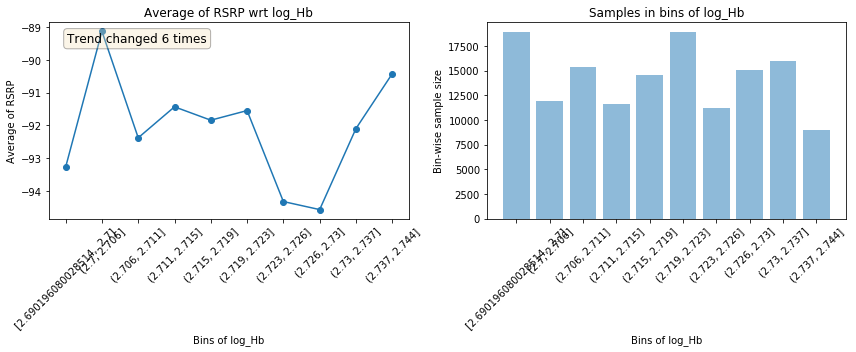

                                           Test data plots                                            


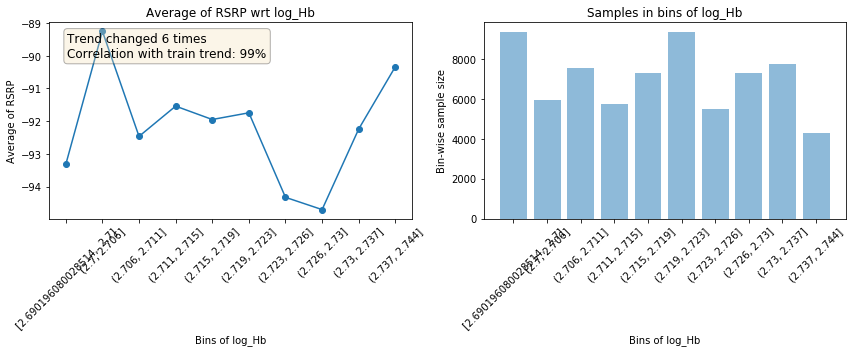

--------------------------------------------------------------------------------------------------------------


                                           Plots for log_Hu                                           
                                           Train data plots                                           


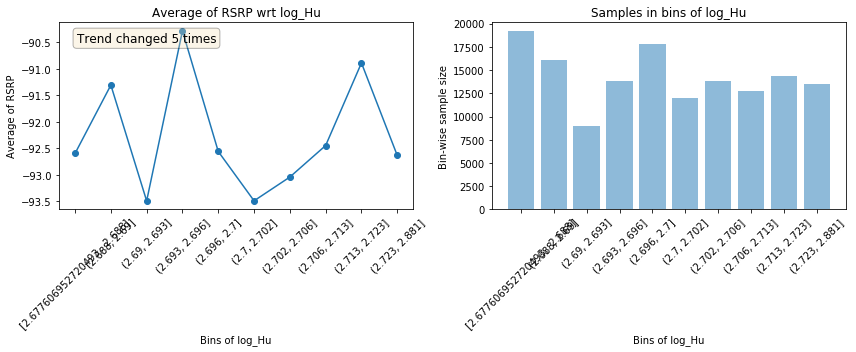

                                           Test data plots                                            


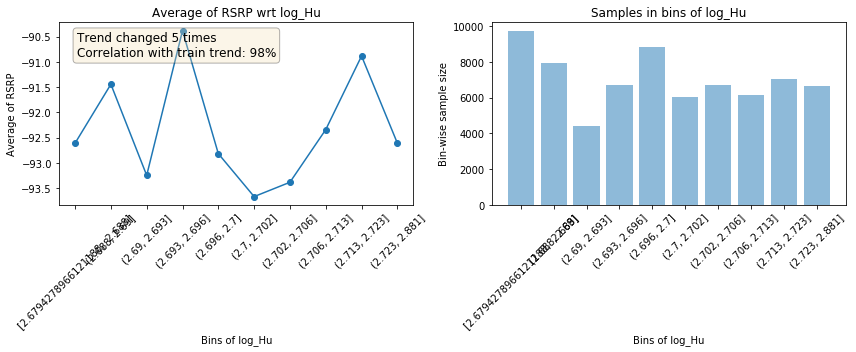

--------------------------------------------------------------------------------------------------------------


                                          Plots for log_HuA                                           
                                           Train data plots                                           


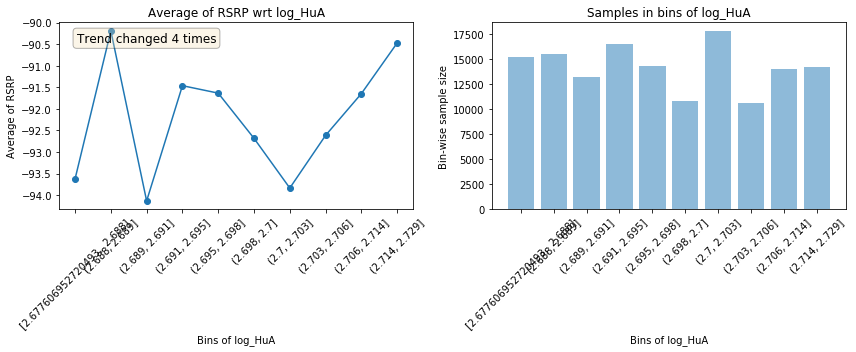

                                           Test data plots                                            


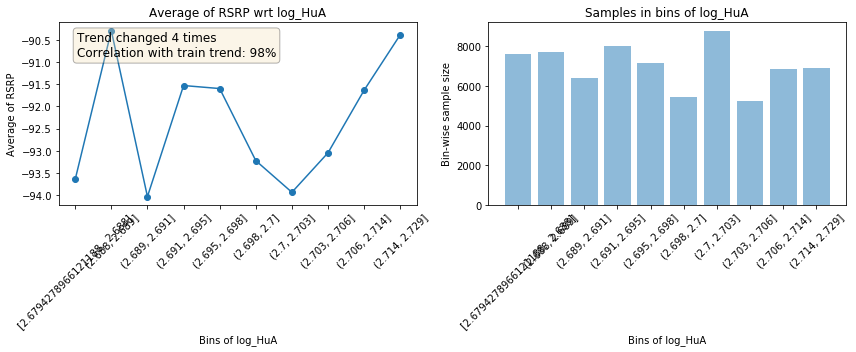

--------------------------------------------------------------------------------------------------------------


                                          Plots for log_dHv                                           
                                           Train data plots                                           


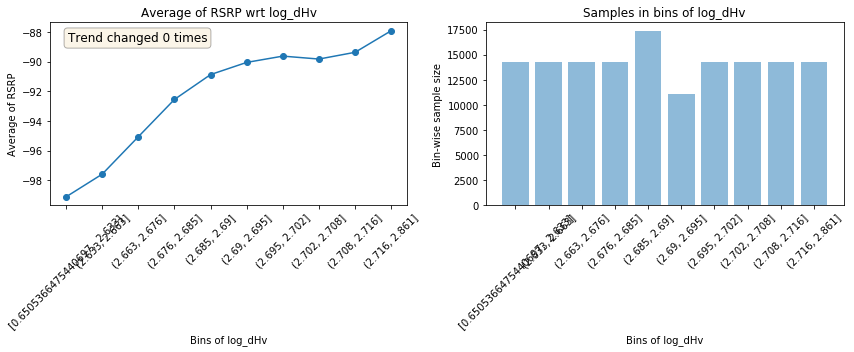

                                           Test data plots                                            


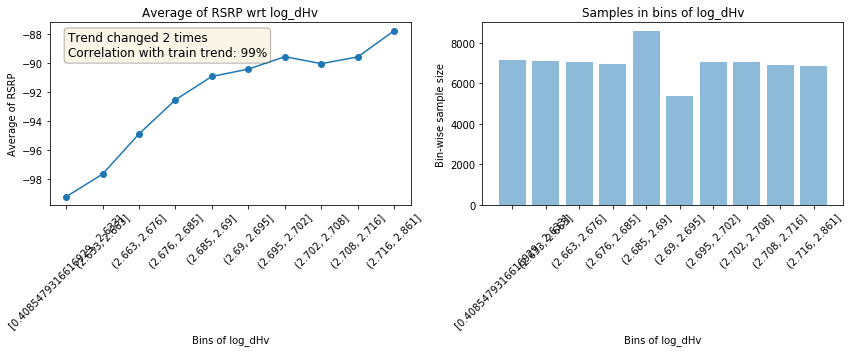

--------------------------------------------------------------------------------------------------------------


                                         Plots for log_Hb-Hu                                          
                                           Train data plots                                           


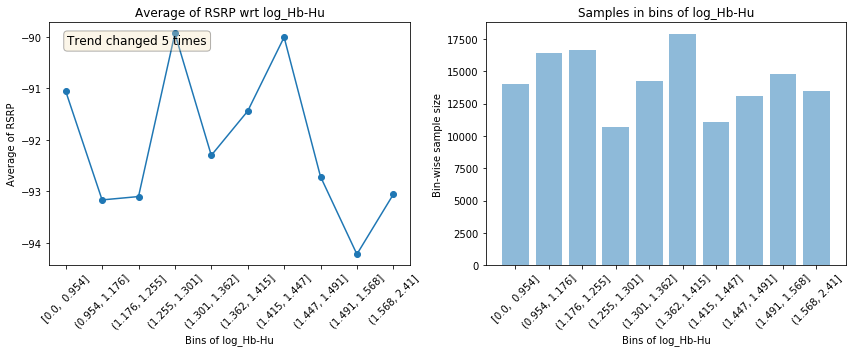

                                           Test data plots                                            


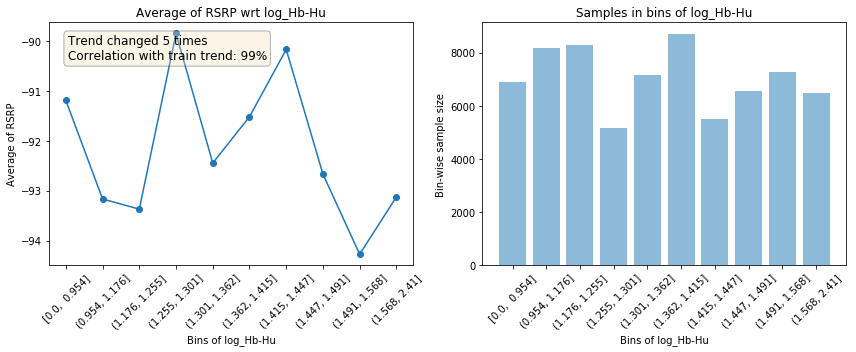

--------------------------------------------------------------------------------------------------------------


                                         Plots for log_Hb-HuA                                         
                                           Train data plots                                           


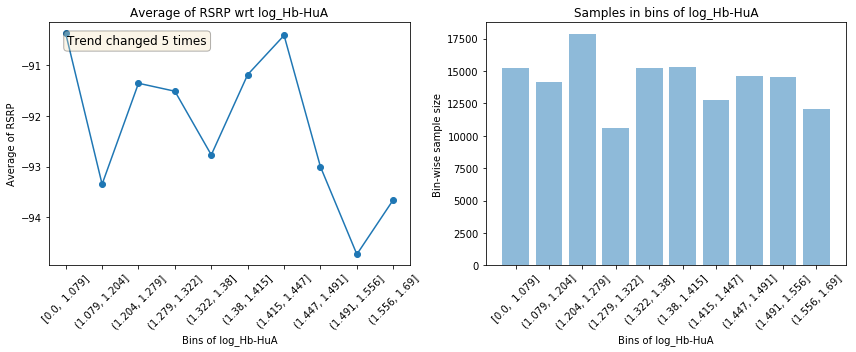

                                           Test data plots                                            


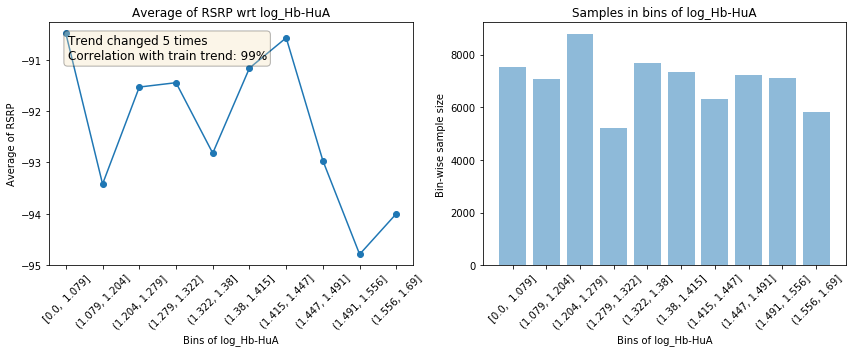

--------------------------------------------------------------------------------------------------------------


                                       Plots for log_Hb-Hu-dHv                                        
                                           Train data plots                                           


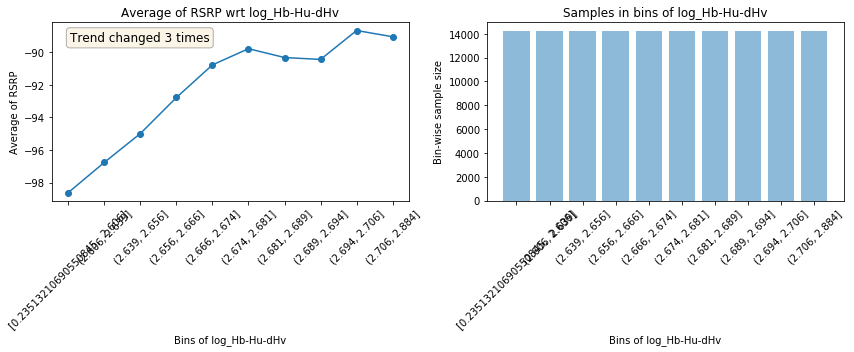

                                           Test data plots                                            


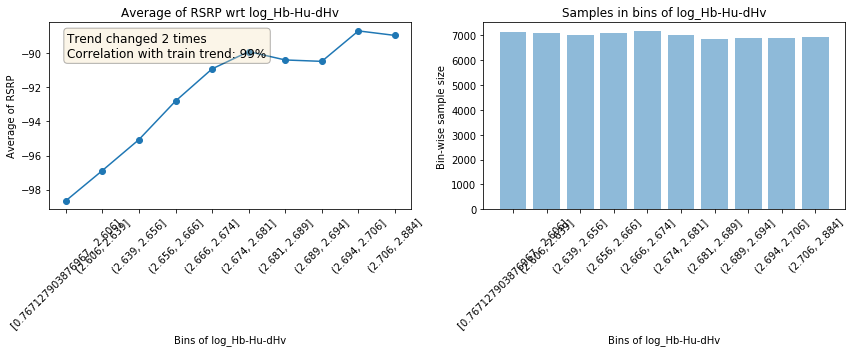

--------------------------------------------------------------------------------------------------------------


                                       Plots for log_Hb-HuA-dHv                                       
                                           Train data plots                                           


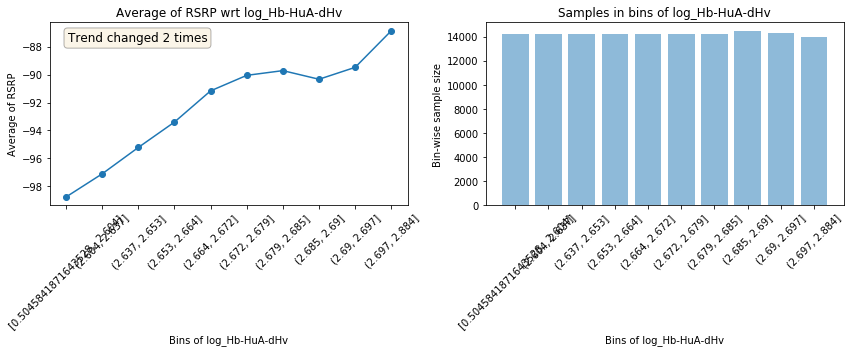

                                           Test data plots                                            


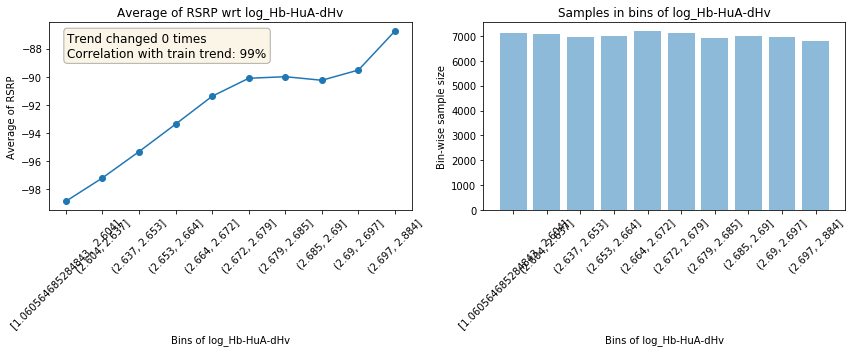

--------------------------------------------------------------------------------------------------------------


                                         Plots for theta_XY_A                                         
                                           Train data plots                                           


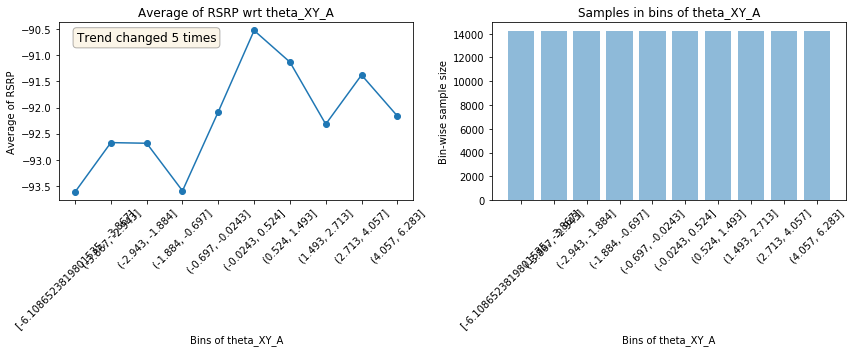

                                           Test data plots                                            


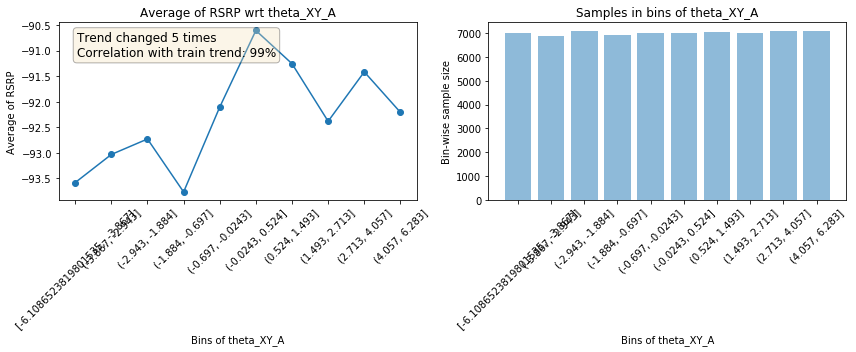

--------------------------------------------------------------------------------------------------------------


                                            Plots for Larc                                            
                                           Train data plots                                           


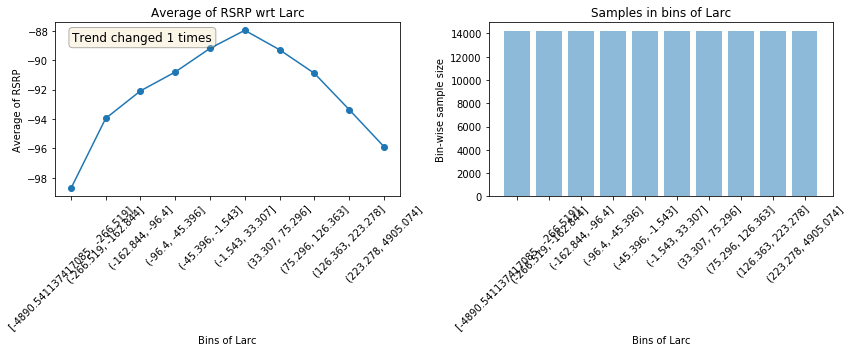

                                           Test data plots                                            


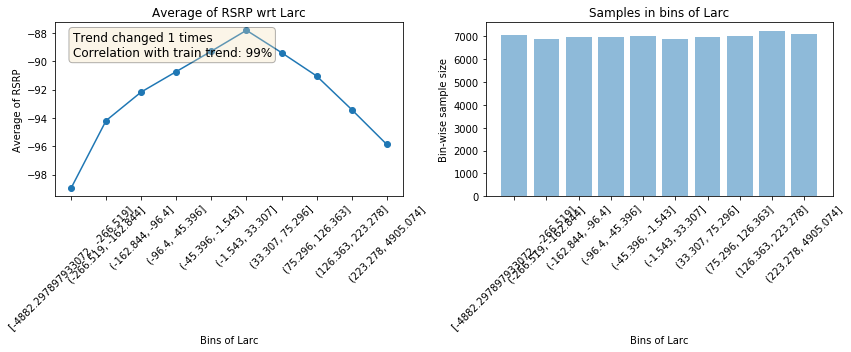

--------------------------------------------------------------------------------------------------------------


                                          Plots for theta_T                                           
                                           Train data plots                                           


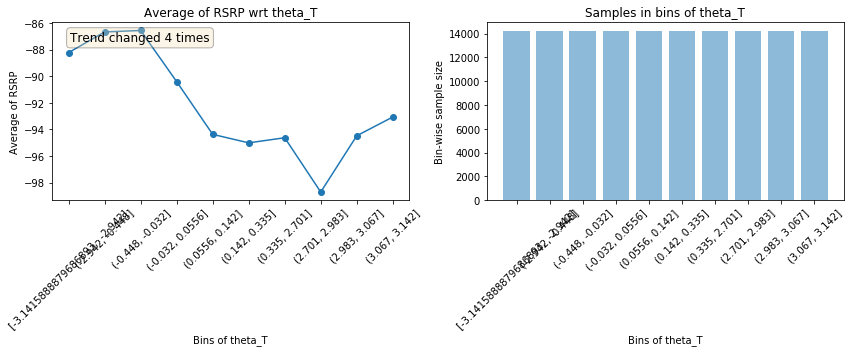

                                           Test data plots                                            


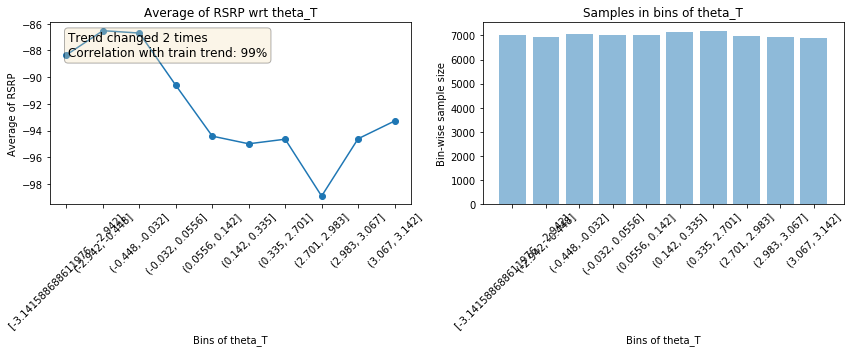

--------------------------------------------------------------------------------------------------------------


                                          Plots for theta_T1                                          
                                           Train data plots                                           


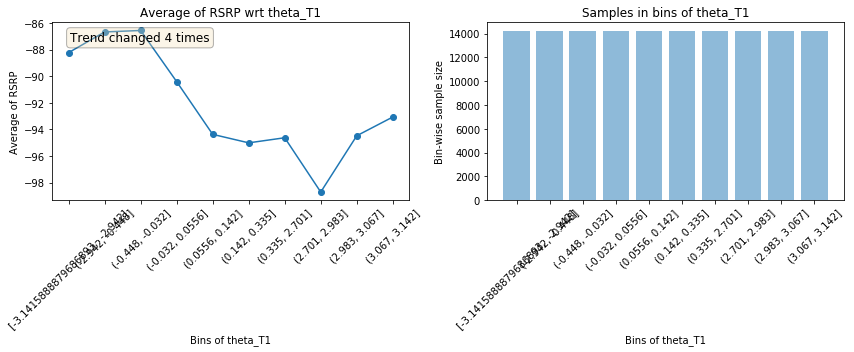

                                           Test data plots                                            


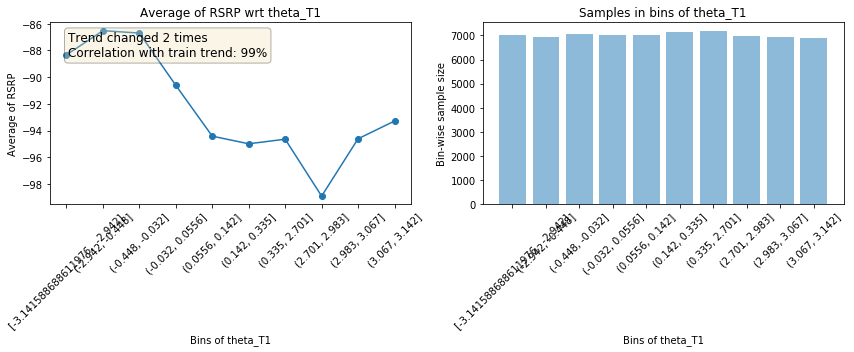

--------------------------------------------------------------------------------------------------------------


                                          Plots for logLarc                                           
                                           Train data plots                                           


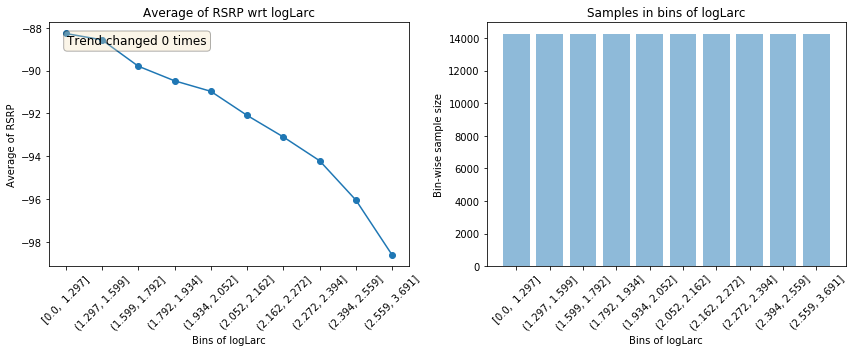

                                           Test data plots                                            


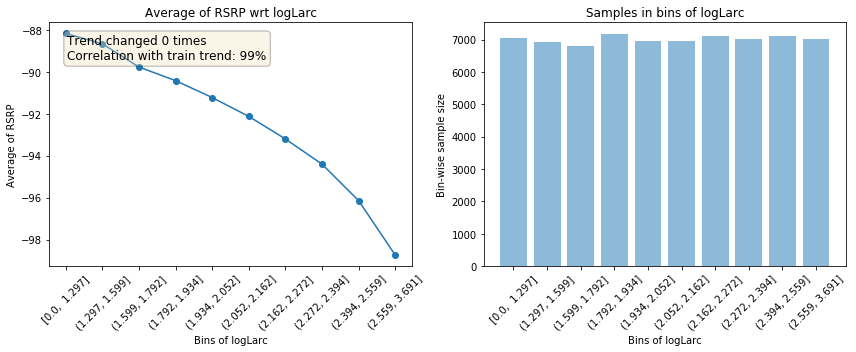

--------------------------------------------------------------------------------------------------------------


                                         Plots for Amplitude                                          
                                           Train data plots                                           


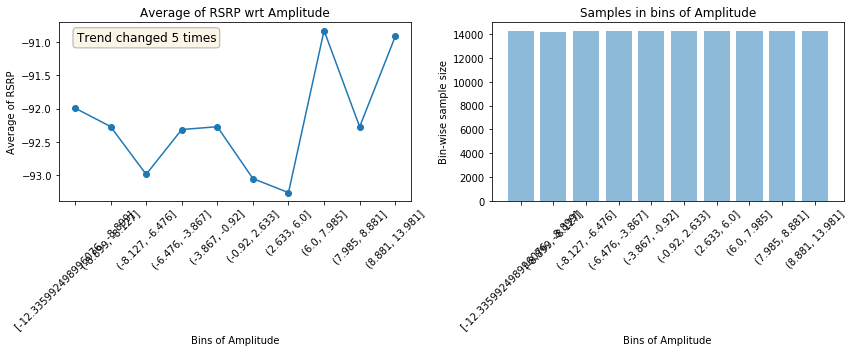

                                           Test data plots                                            


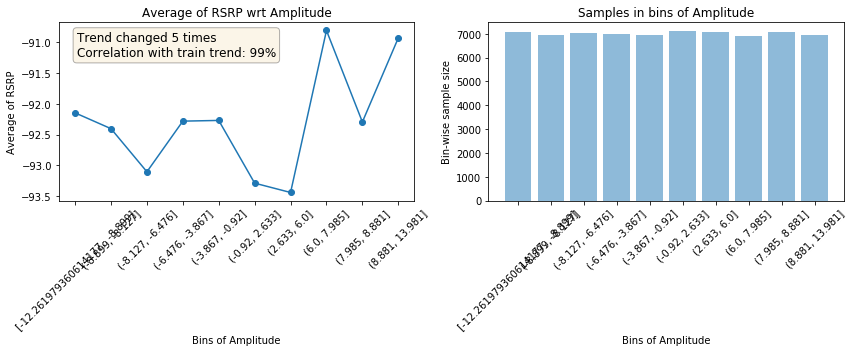

--------------------------------------------------------------------------------------------------------------


                                         Plots for dAmplitude                                         
                                           Train data plots                                           


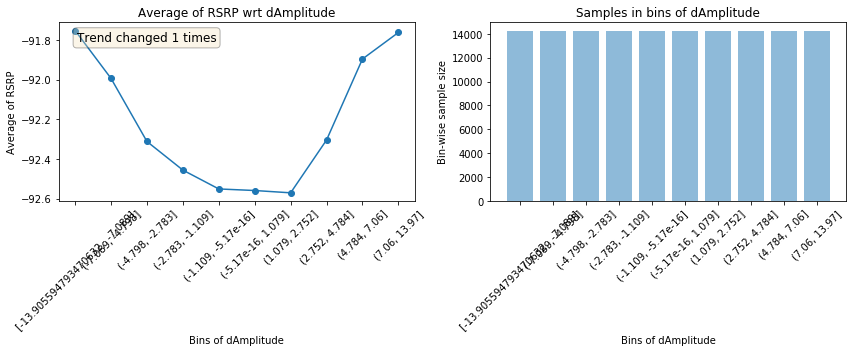

                                           Test data plots                                            


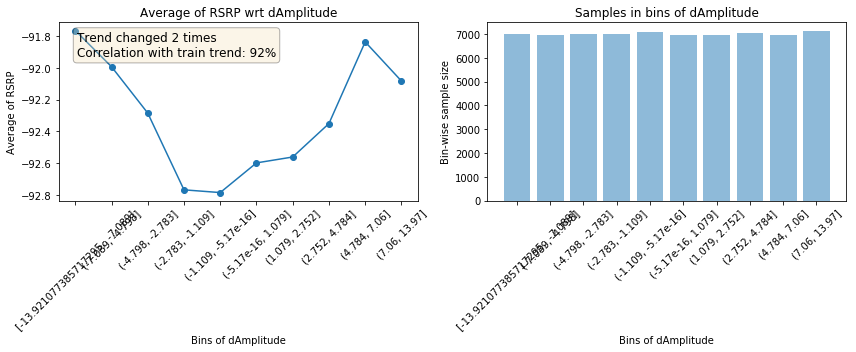

--------------------------------------------------------------------------------------------------------------


                                        Plots for dHvAmplitude                                        
                                           Train data plots                                           


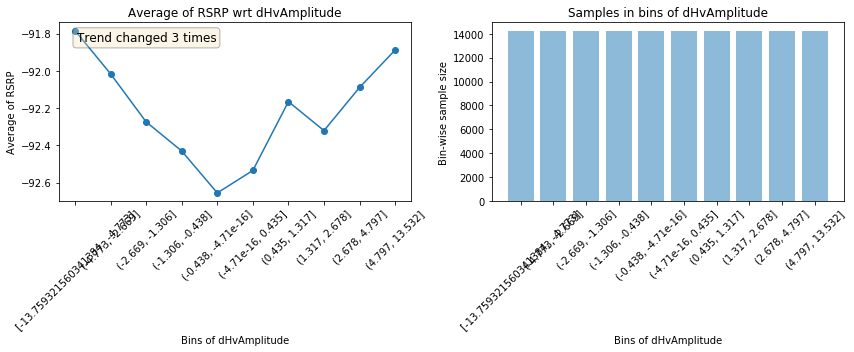

                                           Test data plots                                            


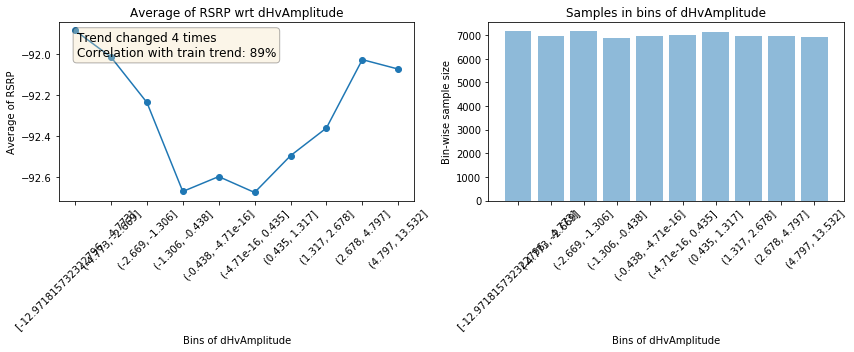

--------------------------------------------------------------------------------------------------------------


                                        Plots for cos_thetaME                                         
                                           Train data plots                                           


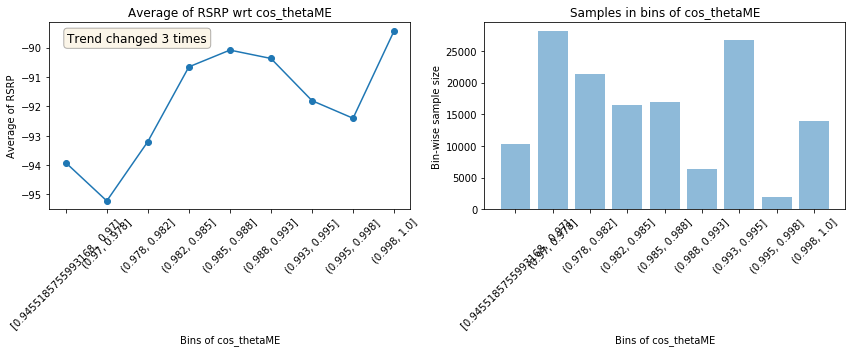

                                           Test data plots                                            


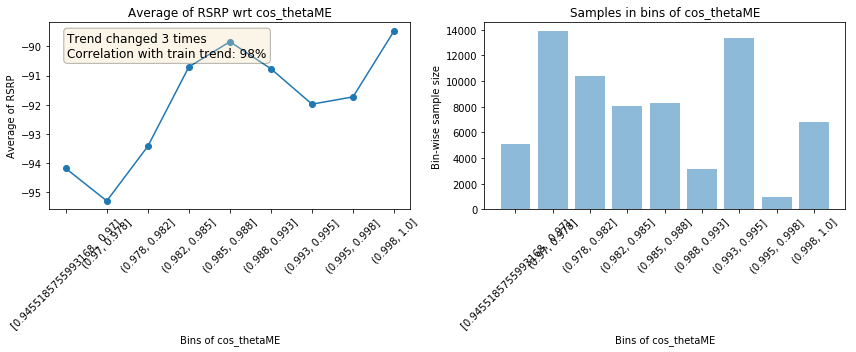

--------------------------------------------------------------------------------------------------------------


                                        Plots for cos_theta_T                                         
                                           Train data plots                                           


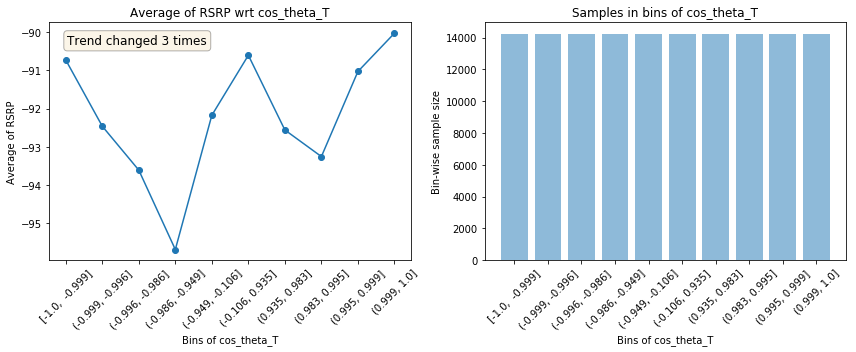

                                           Test data plots                                            


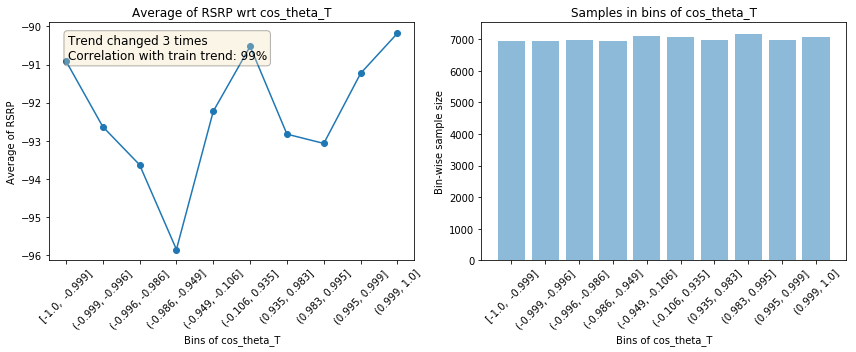

--------------------------------------------------------------------------------------------------------------


                                       Plots for cos_theta_b-u                                        
                                           Train data plots                                           


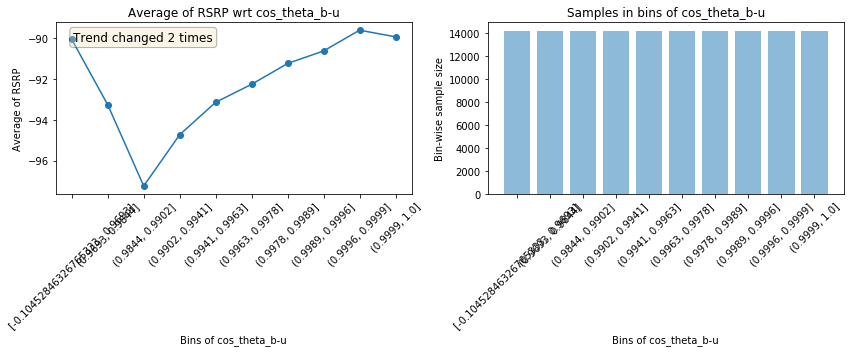

                                           Test data plots                                            


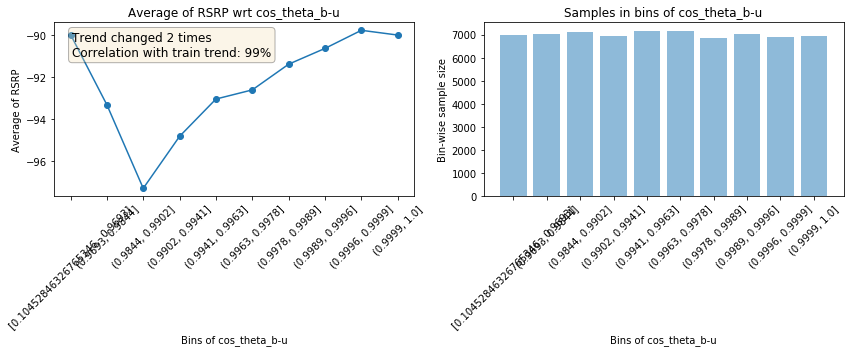

--------------------------------------------------------------------------------------------------------------


                                       Plots for cos_theta_b-uA                                       
                                           Train data plots                                           


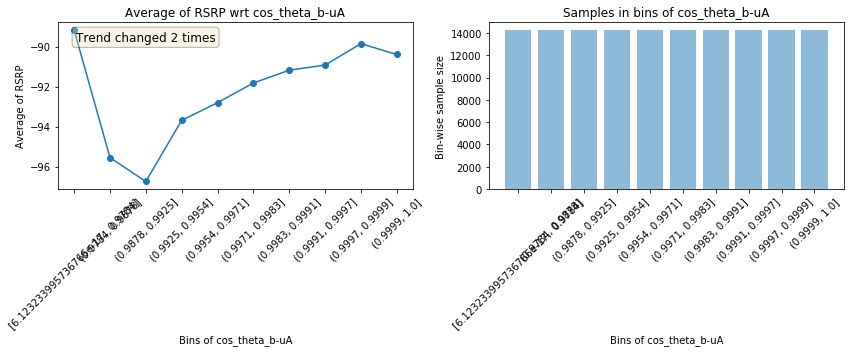

                                           Test data plots                                            


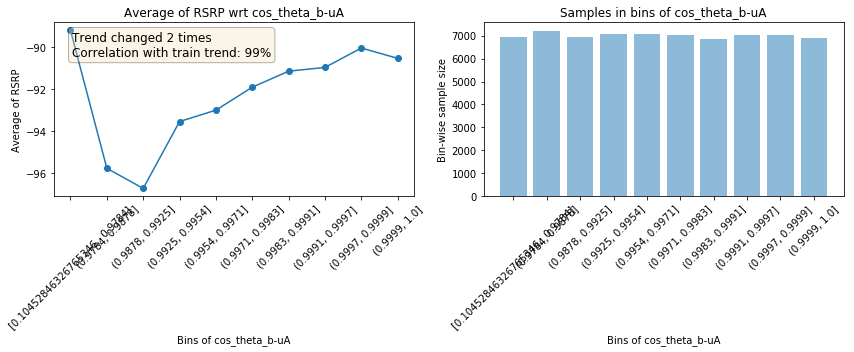

--------------------------------------------------------------------------------------------------------------


                                       Plots for cos_theta_XY_A                                       
                                           Train data plots                                           


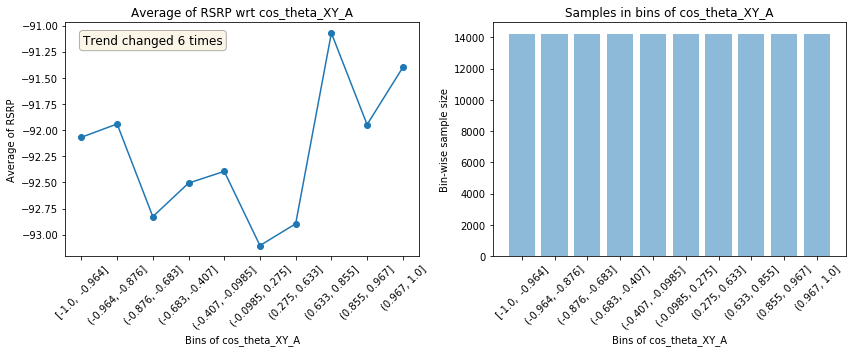

                                           Test data plots                                            


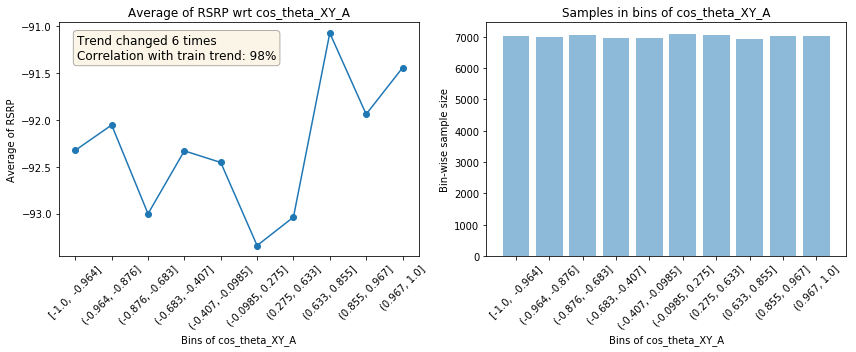

--------------------------------------------------------------------------------------------------------------




In [74]:
train, test= train_test_split(train_sets[2624.6],test_size=0.33, random_state=42)
get_univariate_plots(data=train, target_col='RSRP', data_test=test, features_list=features)

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 432x288 with 0 Axes>

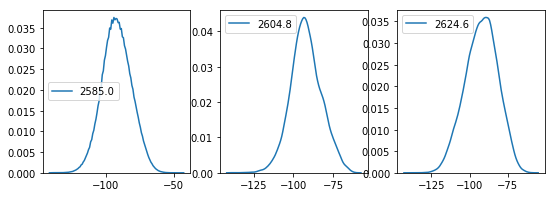

In [8]:
#trainSet1,ValSet1=train_test_split(train_sets,test_size=0.33, random_state=42)
#trainSet2,ValSet2=train_test_split(train_sets,test_size=0.33, random_state=42)
#trainSet3,ValSet3=train_test_split(train_sets,test_size=0.33, random_state=42)

#gc.collect()
plt.figure()
fig, ax = plt.subplots(1,3,figsize=(9,3))
i=0
for key in dataSetKey:
    i += 1
    plt.subplot(1,3,i)
    sns.kdeplot(train_sets[key]['RSRP'],label=key)
    


C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


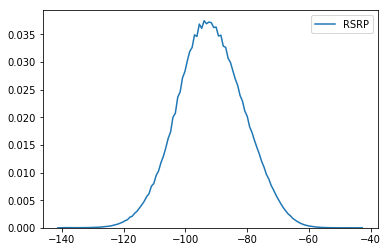

In [345]:
sns.kdeplot(train_data['RSRP'])

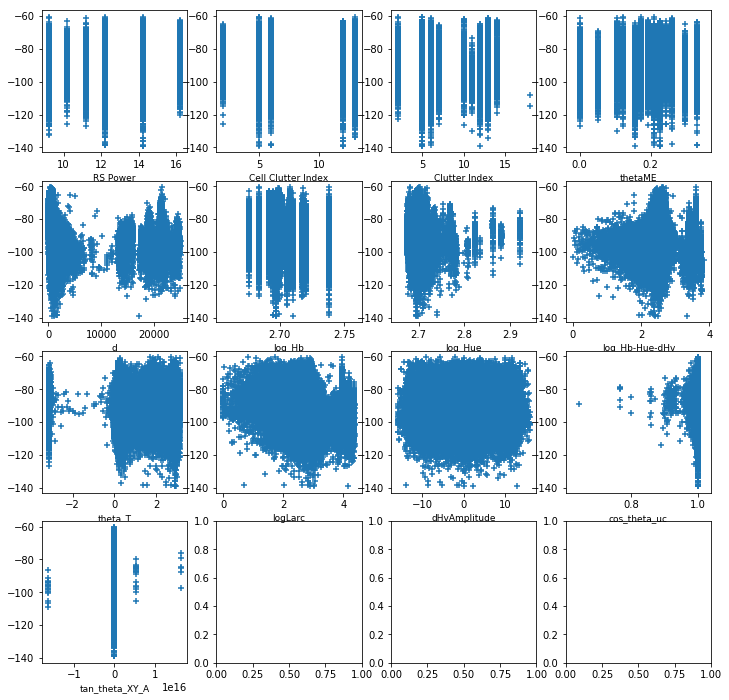

In [208]:
fig, ax = plt.subplots(4,4,figsize=(12,12))
i=0
for f in features:
    i += 1
    plt.subplot(4,4,i)
    plt.scatter(train_sets[2604.8][f],train_sets[2604.8]['RSRP'],marker='+')
    #plt.scatter(train_df[feature], target, marker='+')
    plt.xlabel(f, fontsize=9)
plt.show();

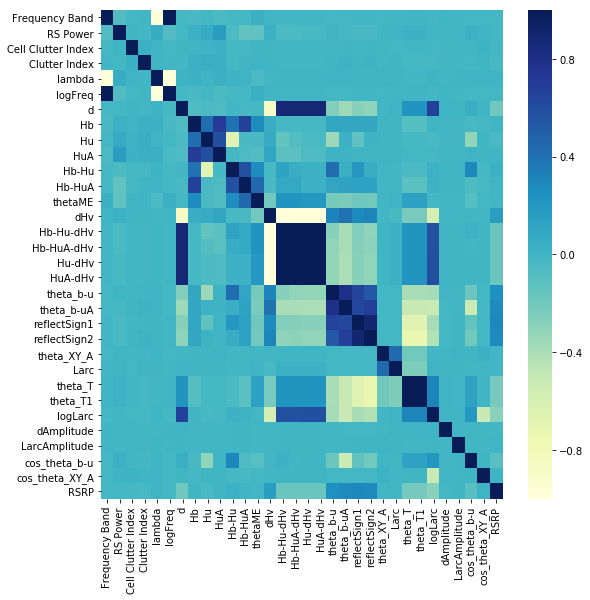

In [243]:
fig, ax = plt.subplots(figsize = (9,9))
sns.heatmap(trainSet2[features].corr() ,cmap="YlGnBu")

In [57]:
#para
def display_importances(feature_importance_df_):
    cols = feature_importance_df_[["Feature", "importance"]].groupby("Feature").mean().sort_values(by="importance", ascending=False)[:40].index
    best_features = feature_importance_df_.loc[feature_importance_df_.Feature.isin(cols)]
    plt.figure(figsize=(8, 10))
    sns.barplot(x="importance", y="Feature", data=best_features.sort_values(by="importance", ascending=False))
    plt.title('LightGBM Features (avg over folds)')
    plt.tight_layout()
    plt.show()
    
params = {
    'learning_rate': 0.08,
    'boosting_type': 'gbdt',
    'objective': 'regression_l2',
    'metric': 'mse',
    'feature_fraction': 0.6,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'num_leaves': 200,
    'verbose': -1,
    'max_depth': -1,
    'reg_alpha':0.2,
    'reg_lambda':0.4,
    'nthread': 8
}

def lgb_reg(params,train,targets,test):
    feature=train.columns
    folds = KFold(n_splits=5, shuffle=True, random_state=1420)
    oof = np.zeros(len(train))
    predictions = np.zeros(len(test))
    feature_importance_df = pd.DataFrame()
    for fold_, (trn_idx, val_idx) in enumerate(folds.split(train.values, targets.values)):
        print("Fold {}".format(fold_))
        #n=len(trn_idx)
        trn_data = lgb.Dataset(train.iloc[trn_idx][feature],label=targets.iloc[trn_idx])
        val_data = lgb.Dataset(train.iloc[val_idx][feature],label=targets.iloc[val_idx])
    
        num_round = 20000
        clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
        oof[val_idx] = clf.predict(train.iloc[val_idx][feature], num_iteration=clf.best_iteration)
        
        fold_importance_df = pd.DataFrame()
        fold_importance_df["Feature"] = feature
        fold_importance_df["importance"] = clf.feature_importance()
        fold_importance_df["fold"] = fold_ + 1
        feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)
        
        predictions += clf.predict(test[feature], num_iteration=clf.best_iteration) / folds.n_splits
    Score=mean_absolute_error(targets, oof)
    print("CV score: {:<8.5f}".format(Score))
    return oof,predictions,feature_importance_df

In [89]:
features1=['RS Power', 'Cell Clutter Index', 'Clutter Index', 'd', 'Hu-dHv', 'theta_b-u','theta_T',
 'theta_b-uA', 'log_dHv', 'log_Hb-Hu-dHv', 'log_Hb-HuA-dHv', 'theta_XY_A', 'logLarc','log_Hb','log_Hu',
 'Amplitude']
trainSet1,ValSet1=train_test_split(train_sets[2624.6],test_size=0.33, random_state=2019)
oof,predictions,feature_importance_df=lgb_reg(params,trainSet1[features1],trainSet1['RSRP'],ValSet1[features1])

Fold 0
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 9.21133	valid_1's l2: 23.6616
Early stopping, best iteration is:
[1056]	training's l2: 8.88106	valid_1's l2: 23.6428
Fold 1
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 9.33456	valid_1's l2: 23.8037
Early stopping, best iteration is:
[1151]	training's l2: 8.47671	valid_1's l2: 23.7908
Fold 2
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 9.36847	valid_1's l2: 23.2095
Early stopping, best iteration is:
[1056]	training's l2: 9.02349	valid_1's l2: 23.2041
Fold 3
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 9.26619	valid_1's l2: 24.148
Early stopping, best iteration is:
[1033]	training's l2: 9.05775	valid_1's l2: 24.1384
Fold 4
Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 9.27486	valid_1's l2: 23.3977
Early stopping, best iteration is:
[923]	tr

In [75]:
features

['RS Power',
 'Cell Clutter Index',
 'Clutter Index',
 'thetaME',
 'd',
 'Hb',
 'Hu',
 'HuA',
 'Hb-Hu',
 'Hb-HuA',
 'dHv',
 'Hb-Hu-dHv',
 'Hb-HuA-dHv',
 'Hu-dHv',
 'HuA-dHv',
 'theta_b-u',
 'theta_b-uA',
 'log_Hb',
 'log_Hu',
 'log_HuA',
 'log_dHv',
 'log_Hb-Hu',
 'log_Hb-HuA',
 'log_Hb-Hu-dHv',
 'log_Hb-HuA-dHv',
 'theta_XY_A',
 'Larc',
 'theta_T',
 'theta_T1',
 'logLarc',
 'Amplitude',
 'dAmplitude',
 'dHvAmplitude',
 'cos_thetaME',
 'cos_theta_T',
 'cos_theta_b-u',
 'cos_theta_b-uA',
 'cos_theta_XY_A']

C:\Users\lenovo\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


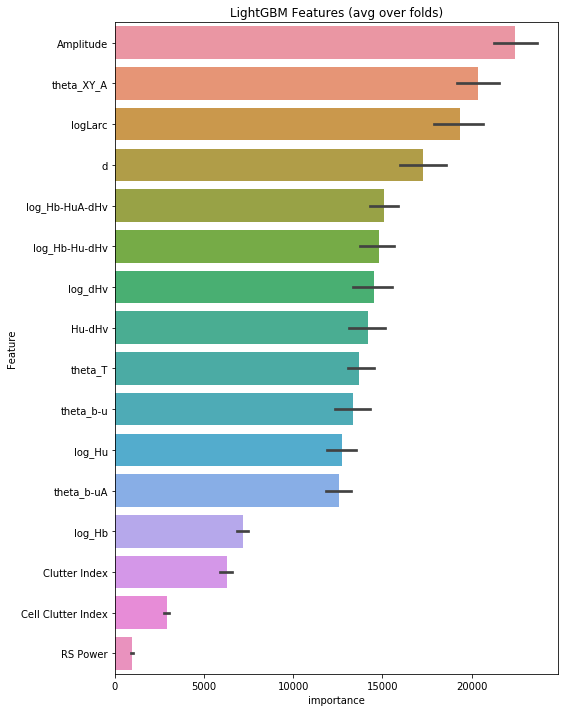

In [92]:
display_importances(feature_importance_df)

In [52]:
feature_importance_df = pd.DataFrame()
trn_data = lgb.Dataset(trainSet2[features1],label=trainSet2['RSRP'])
val_data = lgb.Dataset(ValSet2[features1],label=ValSet2['RSRP'])
num_round = 20000
clf = lgb.train(params, trn_data, num_round, valid_sets = [trn_data, val_data], verbose_eval=1000, early_stopping_rounds = 200)
fold_importance_df = pd.DataFrame()
fold_importance_df["Feature"] = features1
fold_importance_df["importance"] = clf.feature_importance()

Training until validation scores don't improve for 200 rounds.
[1000]	training's l2: 40.7369	valid_1's l2: 64.9589
[2000]	training's l2: 25.8573	valid_1's l2: 62.2591
[3000]	training's l2: 17.4534	valid_1's l2: 61.2703
[4000]	training's l2: 12.1002	valid_1's l2: 60.831
[5000]	training's l2: 8.61437	valid_1's l2: 60.6379
[6000]	training's l2: 6.23383	valid_1's l2: 60.5775
Early stopping, best iteration is:
[5903]	training's l2: 6.43022	valid_1's l2: 60.5634


In [37]:
#features1=['dHvAmplitude','dAmplitude','Amplitude','cos_theta_XY_A','d','logLarc','Hb','cos_theta_b-u',
#         'theta_T','Hu','dHv','theta_b-uA','Hb-HuA-dHv','Cell Clutter Index', 'Clutter Index',
#         'thetaME','RS Power']


In [34]:
#plt.figure(figsize=(8, 10))
#sns.barplot(x="importance", y="Feature", data=fold_importance_df.sort_values(by="importance", ascending=False))
#plt.title('LightGBM Features (avg over folds)')
#plt.tight_layout()
#plt.show()

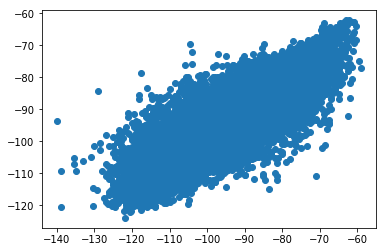

In [90]:
plt.scatter(ValSet1['RSRP'],predictions)

In [91]:
def CaculatePcrr(y_true,y_pred):
    t=-103
    tp=len(y_true[(y_true<t)&(y_pred<t)])
    fp=len(y_true[(y_true>=t)&(y_pred<t)])
    fn=len(y_true[(y_true<t)&(y_pred>=t)])
    precision=tp/(tp+fp)
    recall=tp/(tp+fn)
    pcrr=2*(precision*recall)/(precision+recall)
    return pcrr
CaculatePcrr(ValSet1['RSRP'],predictions)

0.7205233681915052